In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tqdm.keras import TqdmCallback

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

import pandas as pd
import numpy as np
import seaborn as sns
from pandas.core.indexing import _IndexSlice
import matplotlib.pyplot as plt
from functools import partial
import umap
from sklearn.preprocessing import StandardScaler
from pandas.core.dtypes.common import is_numeric_dtype

from pathlib import Path

idx: _IndexSlice = pd.IndexSlice

In [2]:
# Define the path to the data
DATA_PATH = Path("data/01_known_effects")

In [3]:
# Load the list of samples
samples = pd.read_csv(
    DATA_PATH / "experiments.csv",
    index_col=0,
    decimal=","
    )

# Create an index from the experiment table
samples_index_fields = {
        'Label': "label",
        'Effect in PSET':"effect",
        'Treatment': "treatment",
        'Experimenter, location': "experimenter_location",
        'Strain': "strain",
        'CO2 level': "CO2_level",
        'Cultivation + experiment temperature': "temperature",
        'Cultivation light intensity': "Light_intensity",
        'Dark or light acclimated': "light_acclimation",
        'Growth light color (nm)': "light_color",
        'Cultivator': "cultivator",
        'Medium': "medium",
        'Fluorometer': "fluorometer",
        'SP color (nm)': "SP_color",
        'SP intensity': "SP_intensity",
        'Measuring vessel': "vessel",
        'OD680 MC-1000': "OD680",
        'OD720 MC-1000': "OD720",
        'ΔOD': "deltaOD",
        'OD680/720 raw': "OD680_720",
}
samples_index_fields_inv = {v:k for k,v in samples_index_fields.items()}

samples_index = pd.MultiIndex.from_frame(
    samples.reset_index().loc[:, list(samples_index_fields.keys())]
)

In [4]:
def get_index_levels(df, level):
    columns = df.columns.remove_unused_levels()
    
    # Get the levels and the index corresponding to the level
    _level = samples_index_fields_inv[level]
    level_ind = np.where(np.array(list(df.columns.names)) == _level)[0][0]
    return list(columns.levels[level_ind])

In [ ]:
# Summary statistics
fig, axes = plt.subplots(
    int(np.ceil(len(samples.columns[2:])/3)), 
    3,
    figsize = (7, 15)
)

for column, ax in zip(samples.columns[2:], axes.flatten()):
    # Get the values dor each column and count the occurrences
    dat = samples.loc[:,column]
    if not is_numeric_dtype(dat.dtype):
        dat = dat.value_counts()
        dat.plot(kind="bar", ax=ax)
        ax.set_xticklabels(ax.get_xticklabels(), rotation=10, ha='right')
    else:
        dat.plot(kind="hist", ax=ax)

    ax.set_title(column, size=10)
    ax.set_ylabel("")
    ax.set_xlabel("")

fig.subplots_adjust(
    wspace = 0.3,
    hspace=0.7
)

for column in samples.columns[:2]:
    fig, ax = plt.subplots()
    dat = samples.loc[:,column]
    dat = dat.value_counts()
    dat.plot(kind="bar", ax=ax)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    ax.set_title(column, size=10)

In [6]:
# for i in samples_index_fields.values():
#     print(f"{i},")# : str | list[str | int] | slice | None = slice(None),")

# Create a function for easy indexing
def didx(
    label: str | list[str | int] | slice | None = slice(None),
    effect: str | list[str | int] | slice | None = slice(None),
    treatment: str | list[str | int] | slice | None = slice(None),
    experimenter_location: str | list[str | int] | slice | None = slice(None),
    strain: str | list[str | int] | slice | None = slice(None),
    CO2_level: str | list[str | int] | slice | None = slice(None),
    temperature: str | list[str | int] | slice | None = slice(None),
    Light_intensity: str | list[str | int] | slice | None = slice(None),
    light_acclimation: str | list[str | int] | slice | None = slice(None),
    light_color: str | list[str | int] | slice | None = slice(None),
    cultivator: str | list[str | int] | slice | None = slice(None),
    medium: str | list[str | int] | slice | None = slice(None),
    fluorometer: str | list[str | int] | slice | None = slice(None),
    SP_color: str | list[str | int] | slice | None = slice(None),
    SP_intensity: str | list[str | int] | slice | None = slice(None),
    vessel: str | list[str | int] | slice | None = slice(None),
    OD680: str | list[str | int] | slice | None = slice(None),
    OD720: str | list[str | int] | slice | None = slice(None),
    deltaOD: str | list[str | int] | slice | None = slice(None),
    OD680_720: str | list[str | int] | slice | None = slice(None),
) -> int | str | slice:
    res: list[str | list[str | int] | slice | None] = [
        x
        for x in [
            label,
            effect,
            treatment,
            experimenter_location,
            strain,
            CO2_level,
            temperature,
            Light_intensity,
            light_acclimation,
            light_color,
            cultivator,
            medium,
            fluorometer,
            SP_color,
            SP_intensity,
            vessel,
            OD680,
            OD720,
            deltaOD,
            OD680_720,
        ]
        if x is not None
    ]
    return idx[*res]

## Load the data

In [7]:
# Get the paths to the samples files
files = {}

for i in samples_index.get_level_values(0):
    _index = f"{i:04}"

    # Get the file to the current index
    file = list(DATA_PATH.glob(f"ojip_data/{_index}*"))[0]

    # Set the options for reading the data based on the used fluorometer
    if samples.loc[i, "Fluorometer"] == "MULTI-COLOR-PAM":
        skiprows = 0
        skipfooter = 0
        sep=";"
        index_col=0
        select_col = "Fluo, V"
        time_to_ms = 1
    elif samples.loc[i, "Fluorometer"] == "AquaPen":
        skiprows = 7
        skipfooter = 38
        sep=r"\s"
        index_col=0
        select_col = "OJIP"
        time_to_ms = 1e-3
    else:
        print(i, samples.loc[i, "Fluorometer"])
        break

    # Read the data with the pre-defined options
    _df = pd.read_table(
        file,
        skiprows=skiprows,
        skipfooter=skipfooter,
        sep=sep,
        index_col=index_col,
        engine='c' if skipfooter == 0 else 'python'
    )[select_col]

    _df.index = pd.Index(np.round(_df.index * time_to_ms, 2))

    # Save the data
    files[i] = _df

# Concatenate the data
df = pd.DataFrame(files).sort_index(axis=1)
df.columns = samples_index

In [8]:
# Get scaling factors from the fluorometer comparison data
SCALING_DATA_PATH = Path("data/00_fluorometer_data_scaling")

scaling_samples = pd.read_csv(
    SCALING_DATA_PATH / "experiments.csv",
    index_col=0,
    decimal=","
    )

# Get the paths to the samples files
files = {}

for i in scaling_samples.index:
    _index = f"{i:02}"

    # Get the file to the current index
    file = list(SCALING_DATA_PATH.glob(f"ojip_data/{_index}*"))[0]

    # Set the options for reading the data based on the used fluorometer
    if scaling_samples.loc[i, "Fluorometer"] == "MULTI-COLOR-PAM":
        skiprows = 0
        skipfooter = 0
        sep=";"
        index_col=0
        select_col = "Fluo, V"
        time_to_ms = 1
    elif scaling_samples.loc[i, "Fluorometer"] == "AquaPen":
        skiprows = 7
        skipfooter = 38
        sep=r"\s"
        index_col=0
        select_col = "OJIP"
        time_to_ms = 1e-3
    else:
        print(i, scaling_samples.loc[i, "Fluorometer"])
        break

    # Read the data with the pre-defined options
    _df = pd.read_table(
        file,
        skiprows=skiprows,
        skipfooter=skipfooter,
        sep=sep,
        index_col=index_col,
        engine='c' if skipfooter == 0 else 'python'
    )[select_col]

    _df.index = pd.Index(np.round(_df.index * time_to_ms, 2))

    # Save the data
    files[i] = _df

# Concatenate the data
scaling_df = pd.DataFrame(files).sort_index(axis=1)
scaling_df.columns = pd.MultiIndex.from_frame(scaling_samples)

In [9]:
# Determine scaling factors between devices 
factors = pd.DataFrame(index=pd.MultiIndex([[],[],[],[]], [[],[],[],[]], name=["from", "from SP (nm)", "to", "to SP (nm)"]))

for hue in scaling_df.columns.levels[-1]:
    _dat = scaling_df.loc[:,idx[:,:,:,hue]].loc[0:0.05].mean().droplevel([0,-1])
    MCPAM = _dat.loc[idx[["MULTI-COLOR-PAM"], :]]
    AQPEN = _dat.loc[idx[["AquaPen"], :]]
    
    factors.loc[idx[*AQPEN.index[0], *MCPAM.index[0]], "F0"] = (
        MCPAM.iloc[0] / AQPEN.iloc[0]
    )

# factors["Fm"] = (
#     scaling_df.loc[:, idx[:, "MULTI-COLOR-PAM",:]].max().droplevel([0,1,2])
#     / scaling_df.loc[:, idx[:, "AquaPen",:]].max().droplevel([0,1,2])
# )

# factors = pd.DataFrame(factors)

In [10]:
# Determine scaling factors between devices at F0 and FM
factors = pd.DataFrame(index=pd.MultiIndex([[],[],[],[]], [[],[],[],[]], name=["from", "from SP (nm)", "to", "to SP (nm)"]))

for hue in scaling_df.columns.levels[-1]:
    MCPAM = scaling_df.loc[:,idx[:,"MULTI-COLOR-PAM",:,hue]].droplevel([0,-1], axis=1)
    AQPEN = scaling_df.loc[:,idx[:,"AquaPen",:,hue]].droplevel([0,-1], axis=1)
    
    # F0
    factors.loc[idx[*AQPEN.columns[0], *MCPAM.columns[0]], "F0"] = (
        MCPAM.loc[0:0.05].mean().iloc[0] / AQPEN.loc[0:0.05].mean().iloc[0]
    )

    # FM
    factors.loc[idx[*AQPEN.columns[0], *MCPAM.columns[0]], "FM"] = (
        MCPAM.max().iloc[0] / AQPEN.max().iloc[0]
    )

factors["mean"] = factors.mean(axis=1)

### Rescale AquaPen samples

In [11]:
# Rescale AquaPen samples with the determined conversion factors
for (fluorometer, SP_color, _, _), factor in factors["mean"].items():
    try:
        df.loc[:, didx(fluorometer=fluorometer, SP_color=SP_color)] = df.loc[:, didx(fluorometer=fluorometer, SP_color=SP_color)] * factor
    except KeyError:
        pass

## Example plots

In [ ]:
# Example plots

ax = df.loc[:, didx(
    fluorometer="MULTI-COLOR-PAM",
    CO2_level="Air", 
    strain="Chlorella vulgaris",
    # SP_color=455
)].dropna().plot(legend=False)
ax.set_xscale("log")
ax.set_xlabel("Time [ms]")
ax.set_ylabel("Fluorescence [Detector V]")
ax.set_title("MCPAM - Example")

ax = df.loc[:, didx(fluorometer="AquaPen", CO2_level="Air")].dropna().plot(legend=False)
ax.set_xscale("log")
ax.set_xlabel("Time [ms]")
ax.set_ylabel("Fluorescence [AU]")
ax.set_title("AquaPen - Example")

## Training with Feature selection
Exclude AquaPen data until a conversion is found

In Tran2024, nine features were extracted:
- F0
- Fm
- F(50 µs)
- F(100 µs)
- F(300 µs)
- F(2 ms)
- F(30 ms)
- Timing of Fm
- Area above the curve between F0 and Fm

### Potential other features:
- Log-spaced subsampling
- Timing of inflection points (I, J)

## Select the data to be trained on

In [13]:
dat = df.loc[
    0.01:, # Exclude data before the light pulse
    didx(
        fluorometer="MULTI-COLOR-PAM", # Only use MCPAM data
        strain='Synechocystis sp. PCC 6803', # Only use Synechocystis data
    )
].dropna()

In [14]:
# Create a feature table
df_features = pd.DataFrame(index=dat.columns, columns=pd.MultiIndex([[],[]], [[],[]], dtype=[str, float]))

# F0 [AU]
df_features.loc[:, idx["F0 [AU]", np.nan]] = dat.iloc[:3].mean()

# Fm [AU]
df_features.loc[:, idx["Fm [AU]", np.nan]] = dat.max()

# Fm timing [ms]
df_features.loc[:, idx["Fm time [ms]", np.nan]] = dat.idxmax()

In [15]:
# Time points, logspaced
time_points = np.logspace(
    np.log10(dat.index[0]),
    np.log10(dat.index[-1]),
    20
)[1:]

# Pre-populate the interp function
_interp = partial(np.interp, time_points, dat.index)

# Interpolate the selected points
F_sampled = dat.apply(_interp)
F_sampled.index = pd.MultiIndex.from_product([["Fsampled"], time_points])

# Add sampled points to features
df_features = pd.concat([df_features, F_sampled.T], axis=1)

In [ ]:
# Subset the data to the samples and time to be included in the analysis 
ax = dat.plot(legend=False)

for t in time_points:
    ax.axvline(t)

ax.set_xscale("log")

#### UMAP

In [17]:
# Set a random seed for UMAP
UMAP_seed = 2025

In [18]:
# Scale the features
df_features_scaled = StandardScaler().fit_transform(df_features.values)

In [ ]:
# Create the UMAP embedding
reducer = umap.UMAP(random_state=UMAP_seed)
embedding = pd.DataFrame(
    reducer.fit_transform(df_features_scaled),
    index=df_features.index,
    columns=["UMAP_1", "UMAP_2"]
).reset_index()

In [ ]:
# Plot
categories = df.columns.names[1:]
fig, axes = plt.subplots(
    int(np.ceil(len(categories)/3)),
    3,
    figsize=(7,15),
    sharey=True,
    sharex=True,
)

for category, ax in zip(categories, axes.flatten()):
    sns.scatterplot(
        embedding,
        x="UMAP_1",
        y="UMAP_2",
        hue=category,
        ax=ax,
        legend=False
    )
    ax.set_title(category)

    if len(embedding[category].value_counts()) == 1:
        ax.text(s="one category",x=0.98, y=0.98, ha="right", va="top", transform=ax.transAxes, size=7)

fig.tight_layout()

In [ ]:
# Plot single
fig, ax = plt.subplots(figsize=(5,5))
sns.scatterplot(
    embedding,
    x="UMAP_1",
    y="UMAP_2",
    hue="Effect in PSET",
    ax=ax,
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1,1))

### Map the effects

In [22]:
effects_map = pd.read_csv(
    DATA_PATH / "effects_map.csv",
    header=[0,1],
    index_col=[0,1],
    ).astype(float).fillna(0).astype(bool)

In [56]:
# Get the effects and map the mto the targets
effects = samples.loc[df_features.index.get_level_values(0), ["Effect in PSET", "Treatment"]]

df_targets = effects_map.loc[pd.MultiIndex.from_frame(effects)]
df_targets.index = df_features.index

,control_measurement,PSII_closed,CBB_inhibited,high_light,low_light,TOX_inhibited,electron_drain,low_temperature,high_temperature
Label,,,,,,,,,
7,True,False,False,False,False,False,False,False,False
8,True,False,False,False,False,False,False,False,False
9,True,False,False,False,False,False,False,False,False
10,True,False,False,False,False,False,False,False,False
11,True,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...
220,False,False,False,True,False,False,False,False,False
221,False,False,False,True,False,False,False,False,False
222,False,False,False,True,False,False,False,False,False


In [60]:
# Add UMAP to targets
embedding_targets = pd.concat([
    df_targets.droplevel(-1, axis=1).droplevel(list(range(1,20)), axis=0),
    embedding.set_index("Label").loc[:, ["UMAP_1", "UMAP_2"]],
], axis=1)

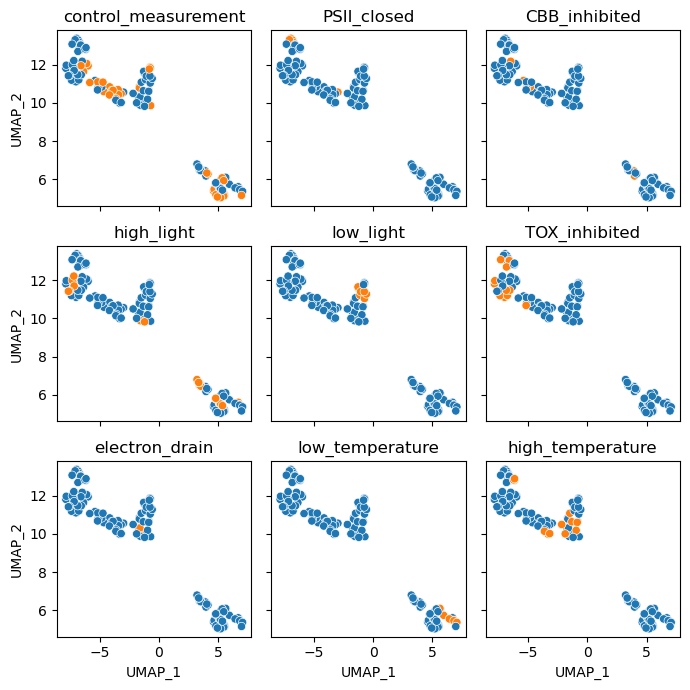

In [61]:
# Plot
categories = effects_map.columns.get_level_values(0)
fig, axes = plt.subplots(
    int(np.ceil(len(categories)/3)),
    3,
    figsize=(7,7),
    sharex=True,
    sharey=True
)

for category, ax in zip(categories, axes.flatten()):
    sns.scatterplot(
        embedding_targets,
        x="UMAP_1",
        y="UMAP_2",
        hue=category,
        ax=ax,
        legend=False
    )
    ax.set_title(category)

    if len(embedding_targets[category].value_counts()) == 1:
        ax.text(s="one category",x=0.98, y=0.98, ha="right", va="top", transform=ax.transAxes, size=7)

fig.tight_layout()

## Create machine learning model

In [62]:
# Split data
X_train, X_test, Y_train, Y_test = train_test_split(
    df_features.astype(int),
    df_targets.astype(int), 
    test_size=0.2, 
    random_state=42,
    stratify=df_targets.values
)

if not np.all(Y_train.drop_duplicates().sum(axis=0) == 1):
    raise RuntimeError("Not all targets are in the training set")

# Scale data
scaler_X = StandardScaler().fit(X_train.values)
scaler_Y = StandardScaler().fit(Y_train.values)

X_train_scaled = scaler_X.transform(X_train.values)
X_test_scaled = scaler_X.transform(X_test.values)

Y_train_scaled = scaler_Y.transform(Y_train.values)
Y_test_scaled = scaler_Y.transform(Y_test.values)

print(f"Training model to recognize {Y_train.shape[1]} target features.\nUsing {X_train.shape[0]} samples with {X_train.shape[1]} features.")

Training model to recognize 9 target features.
Using 100 samples with 22 features.


In [64]:
# Define the model
model = Sequential([
    Input((X_train_scaled.shape[1],)),
    Dense(64, activation='relu'),  # Input layer
    Dense(64, activation='relu'),  # Hidden layer
    Dense(Y_train_scaled.shape[1])  # Output layer with no activation (for regression)
])

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])  # MSE for regression

In [65]:
# Train the model
history = model.fit(
    X_train_scaled,
    Y_train_scaled, 
    validation_data=(X_test_scaled, Y_test_scaled),
    epochs=100,
    batch_size=32,
    verbose=0,
    callbacks=[TqdmCallback(verbose=1)]
)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

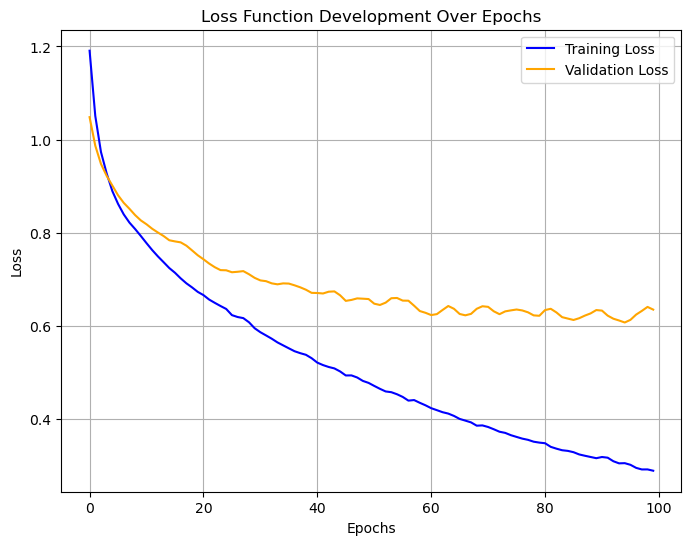

In [66]:
# Extract loss values
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot the loss curves
plt.figure(figsize=(8, 6))
plt.plot(train_loss, label='Training Loss', color='blue')
plt.plot(val_loss, label='Validation Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Function Development Over Epochs')
plt.legend()
plt.grid()
plt.show()

In [67]:
# Evaluate
loss, mae = model.evaluate(X_test_scaled, Y_test_scaled, verbose=0)
print(f"Mean Absolute Error on Test Set: {mae}")


Mean Absolute Error on Test Set: 0.45607882738113403


In [69]:
# Make predictions
Y_pred_scaled = model.predict(X_test_scaled)

# Reverse scale
Y_pred = pd.DataFrame(
    scaler_Y.inverse_transform(Y_pred_scaled),
    index=Y_test.index,
    columns=Y_test.columns,
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Text(0.5, 1.0, 'Validation prediction with threshold 0.5')

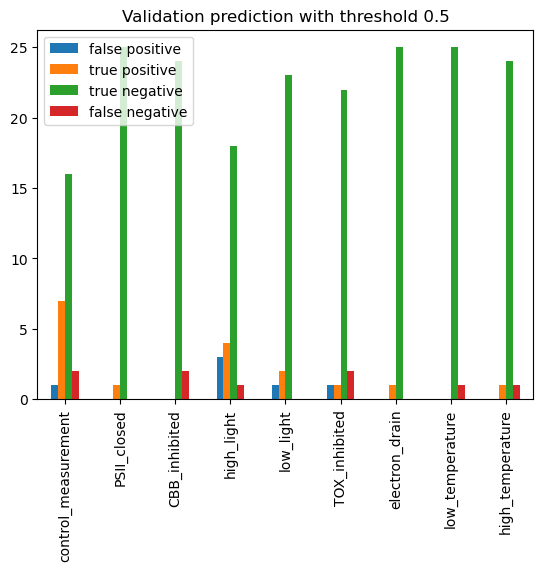

In [71]:
# set the threshold over which the prediction is assessed as True
prediction_threshold = 0.5

# Set the values over the prediction_threshold as True
Y_pred_bool = (Y_pred > prediction_threshold).astype(int)

# Calculate the hits and errors
Y_pred_err = (Y_test - Y_pred_bool * 2)
Y_pred_err = Y_pred_err.apply(lambda x: x.value_counts()).astype(float)

# Map the comparison values to their meaning
error_map = {
    -2: "false positive",
    -1: "true positive",
     0: "true negative",
     1: "false negative"
}
Y_pred_err.index = pd.Index([error_map[x] for x in Y_pred_err.index ])

# Plot
ax = Y_pred_err.droplevel(1, axis=1).T.plot(kind="bar")
ax.set_title(f"Validation prediction with threshold {prediction_threshold}")

### Calculate model metrics

/home/tobias/miniforge3/envs/ojipml/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/tobias/miniforge3/envs/ojipml/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


<Axes: >

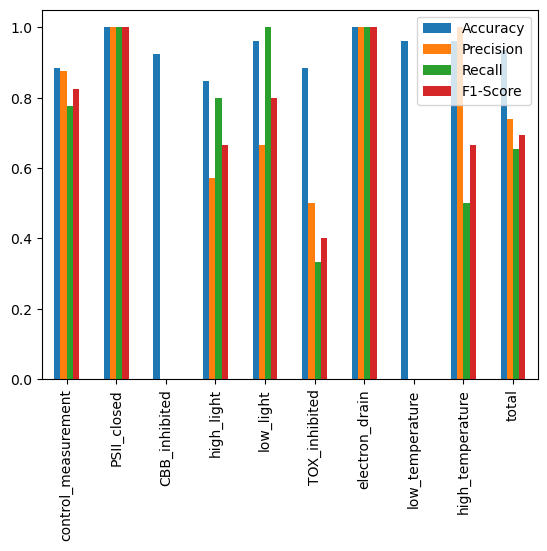

In [100]:
# Calculate model metrics

model_metrics = pd.DataFrame(
    columns = ["Accuracy", "Precision", "Recall", "F1-Score"]
)

for column in list(Y_test.columns.get_level_values(0)) + ["total"]:
    if column == "total":
        Y_test_long = Y_test.droplevel(1, axis=1).stack()
        Y_pred_bool_long = Y_pred_bool.droplevel(1, axis=1).stack()
    else:
        Y_test_long = Y_test.droplevel(1, axis=1)[column]
        Y_pred_bool_long = Y_pred_bool.droplevel(1, axis=1)[column]


    # Total scores
    accuracy = accuracy_score(Y_test_long, Y_pred_bool_long )

    # Calculate precision
    precision = precision_score(Y_test_long, Y_pred_bool_long )

    # Calculate recall (sensitivity)
    recall = recall_score(Y_test_long, Y_pred_bool_long )

    # Calculate F1-score
    f1 = f1_score(Y_test_long, Y_pred_bool_long )

    model_metrics.loc[column, :] = (accuracy, precision, recall, f1)

# Plot
model_metrics.plot(kind="bar")